In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g04b-Fig4b-day12.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day4.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g0-Fig8b-day5.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig5-day0.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/SARS-10.1148rg.242035193-g04mr34g09a-Fig9a-day17.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/ryct.2020200034.fig2.jpeg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA/streptococcus-pneumoniae-pneumonia-temporal-evolution-1-day3.jpg
/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PN

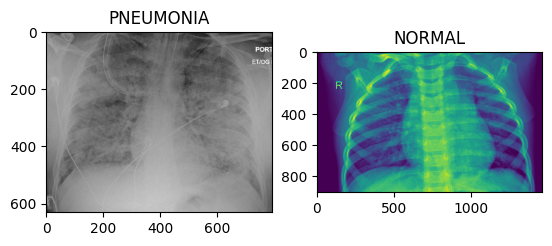

In [2]:
#資料來源 : https://www.kaggle.com/datasets/khoongweihao/covid19-xray-dataset-train-test-sets
import os
import matplotlib.pyplot as plt
from PIL import Image
train_dir = '/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train'
test_dir = '/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test'
train_peneumonia_dir = '/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/PNEUMONIA'
train_normal_dir = '/kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/train/NORMAL'
test_peneumonia_dir = '/Kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/PNEUMONIA'
test_normal_dir = '/Kaggle/input/covid19-xray-dataset-train-test-sets/xray_dataset_covid19/test/NORMAL'

peneumonia_image_path = os.path.join(train_peneumonia_dir, os.listdir(train_peneumonia_dir)[0])
normal_image_path = os.path.join(train_normal_dir, os.listdir(train_normal_dir)[0])

peneumonia_image = Image.open(peneumonia_image_path)
normal_image = Image.open(normal_image_path)


plt.subplot(1, 2, 1)
plt.imshow(peneumonia_image)
plt.title('PNEUMONIA')
plt.subplot(1, 2, 2)
plt.imshow(normal_image)
plt.title('NORMAL')
plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    #縮放像素
    rescale=1./255,
    #旋轉角度
    rotation_range=20,
    #水平平移
    width_shift_range=0.2,
    #垂直平移
    height_shift_range=0.2,
    #水平翻轉
    horizontal_flip=True,
    fill_mode ='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255.0)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode="binary")
test_generator = test_datagen.flow_from_directory(test_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode="binary")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Found 148 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


In [4]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from tensorflow.keras.models import Sequential

#transfer learning(VGG16)
# VGG16架構 2conv + 1pooling 重複五次
model = Sequential()
#include_top是否在網路頂部加入3層FC層
vgg16 = VGG16(include_top=False, input_shape=(224, 224, 3), weights="imagenet")
vgg16.trainable = False
model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
print(model.summary())
model.fit(
    train_generator, 
    epochs=10,
    validation_data=test_generator
)
model.save('VGG16')

58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_____________________________________

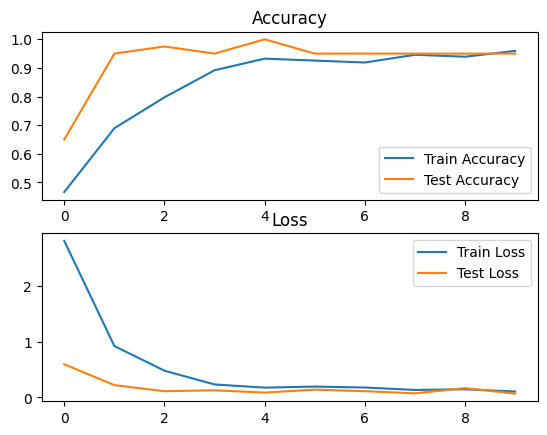

In [5]:
def plot(model):
    plt.subplot(2, 1, 1)
    plt.plot(model.history.history["accuracy"], label="Train Accuracy")
    plt.plot(model.history.history["val_accuracy"], label="Test Accuracy")
    plt.title("Accuracy")
    plt.legend()
    plt.subplot(2, 1, 2)
    plt.plot(model.history.history["loss"], label="Train Loss")
    plt.plot(model.history.history["val_loss"], label="Test Loss")
    plt.title("Loss")
    plt.legend()
    plt.show()
    
plot(model)

In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])
print(model.summary())

model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 111, 111, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 55, 55, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 55, 55, 128)      

2023-05-17 11:35:04.645122: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_1/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


5/5 [==============================] - 10s 1s/step - loss: 39.0309 - accuracy: 0.5541 - val_loss: 0.2675 - val_accuracy: 1.0000
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 5.2897 - accuracy: 0.7703 - val_loss: 0.3510 - val_accuracy: 1.0000
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 2.2531 - accuracy: 0.8378 - val_loss: 0.5922 - val_accuracy: 0.5500
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 2.6732 - accuracy: 0.7703 - val_loss: 0.5296 - val_accuracy: 0.7000
Epoch 5/10
5/5 [==============================] - 6s 1s/step - loss: 2.1400 - accuracy: 0.8243 - val_loss: 0.3650 - val_accuracy: 0.9750
Epoch 6/10
5/5 [==============================] - 6s 1s/step - loss: 1.0353 - accuracy: 0.8716 - val_loss: 0.7229 - val_accuracy: 0.5000
Epoch 7/10
5/5 [==============================] - 5s 1s/step - loss: 0.7640 - accuracy: 0.8851 - val_loss: 0.5237 - val_accuracy: 0.6500
Epoch 8/10
5/5 [==============================] - 

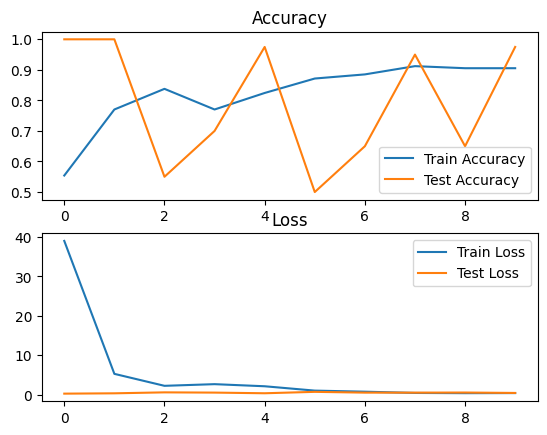

2/2 [==============================] - 1s 132ms/step - loss: 0.4447 - accuracy: 0.9750
[0.4446806013584137, 0.9750000238418579]


In [7]:
plot(model)
print(model.evaluate(test_generator))

In [15]:
classes=['NORMAL','PNEUMONIA']
import numpy as np
def plot_prediction(test_generator, n_images):
    i = 1
    images, labels = test_generator.next()
    predictions = np.argmax(model.predict(images), axis=1)
    labels = labels.astype('int32')
    plt.figure(figsize=(14, 15))
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)
        plt.imshow(image)
        if predictions[i] == labels[i]:
            title_obj = plt.title(classes[label])
            plt.setp(title_obj, color='g') 
            plt.axis('off')
        else:
            title_obj = plt.title(classes[label])
            plt.setp(title_obj, color='r') 
            plt.axis('off')
        i += 1
        if i == n_images:
            break

    plt.show()

1/1 [==============================] - 0s 41ms/step


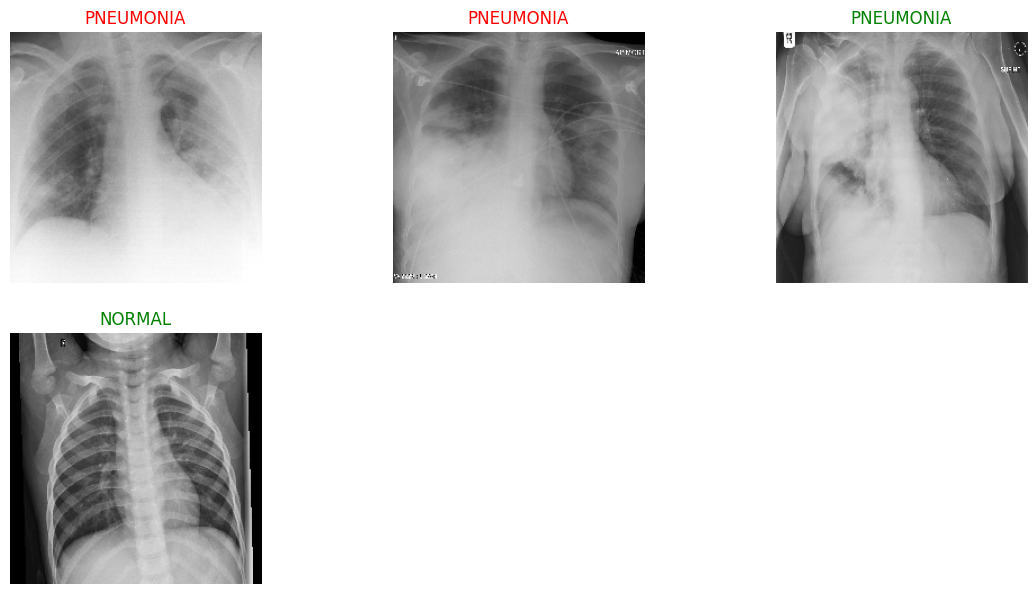

In [16]:
plot_prediction(test_generator,5)